In [1]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

def pearson_spearman(x, y):
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")

    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")

In [1]:
species = 'pig'
model = '7xfw6h3t'

mac_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/{species}_liver_pos_ALL.bed', sep="\t", header=None)
mouse_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/mouse_liver_pos_ALL.bed', sep="\t", header=None)

one_to_one_peaks = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')
pred_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_{species}_VAL.csv', header=None)
val1_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val1/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
# val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val2/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val3/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val2/{species}_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

####################### make the ____ doubled predicted and true df
peaks = one_to_one_peaks[[4, 14]]

merged_df = peaks.merge(mac_qn, how='left', left_on=4, right_on=3, suffixes=('', '_mac'))

# Merge the result with df3 on col13 and df3['col3']
merged_df = merged_df.merge(mouse_qn, how='left', left_on=14, right_on=3, suffixes=('_MAC', '_mouse'))

# Subtract col4 values from df2 and df3
# merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
# res = merged_df[['4', 14, '4_mac', '4_mouse', 'result']]
# nan = res[res.isna().any(axis=1)]

# nan

####################### 

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)

mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_true', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=4, right_on=3).drop(14, axis=1)
# m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = merged_mac_real_pred.rename(columns={3:'mac_peak'}).drop(4, axis=1)

####################### make the mouse doubled predicted and true df

mouse_pred = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_mouse_VAL_TRAIN.csv', sep="\t", header=None)
mouse_real_neg=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', sep="\t", header=None)
mouse_real_pos=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/logPos/mouse_liver_VAL.narrowPeak', sep="\t", header=None)

real_neg_len = 2*len(mouse_real_neg)
real_pos_len = 2*len(mouse_real_pos)

mouse_pred_pos = mouse_pred[real_neg_len:real_neg_len+real_pos_len].reset_index(drop=True)

doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)


doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_true', 0:'mouse_pred'}).reset_index(drop=True)


merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=14, right_on=3)

m_mouse_pred = merged_mouse_pred.rename(columns={3:'mouse_peak'}).drop([14], axis=1)

####################### make bigboss mouse + query predicted and real info

bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)

bigboss['true'] = bigboss['mouse_true']-bigboss['mac_true']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']

mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']


same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
print(f'# of same sign for true difference and predicted difference: {same_sign.sum()} / {len(bigboss)} = {same_sign.sum() / len(bigboss)} %')

same_sign = np.sign(bigboss.loc[::2]['true']) == np.sign(bigboss.loc[::2]['avg_pred'])
print(f'# of same sign for true difference and averaged predicted difference: {same_sign.sum()} / {len(bigboss) / 2} = {same_sign.sum() / (len(bigboss) / 2)}%')

x = bigboss['true']
y = bigboss['pred']

print(pearson_spearman(x, y))

plt.figure(figsize=(8, 8))
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.xlabel(f'mouse real - {species} real')
plt.ylabel(f'mouse pred - {species} pred')
plt.title(f'Foldchange diff in real vs. predicted for model: {model}')
plt.grid(True)
plt.show()

NameError: name 'pd' is not defined

# of same sign for true difference and predicted difference: 469 / 796 = 0.5891959798994975 %
# of same sign for true difference and averaged predicted difference: 244 / 398.0 = 0.6130653266331658%
Pearson correlation coefficient: 0.2349, p-value: 1.936e-11
Spearman correlation coefficient: 0.2436, p-value: 3.239e-12
None


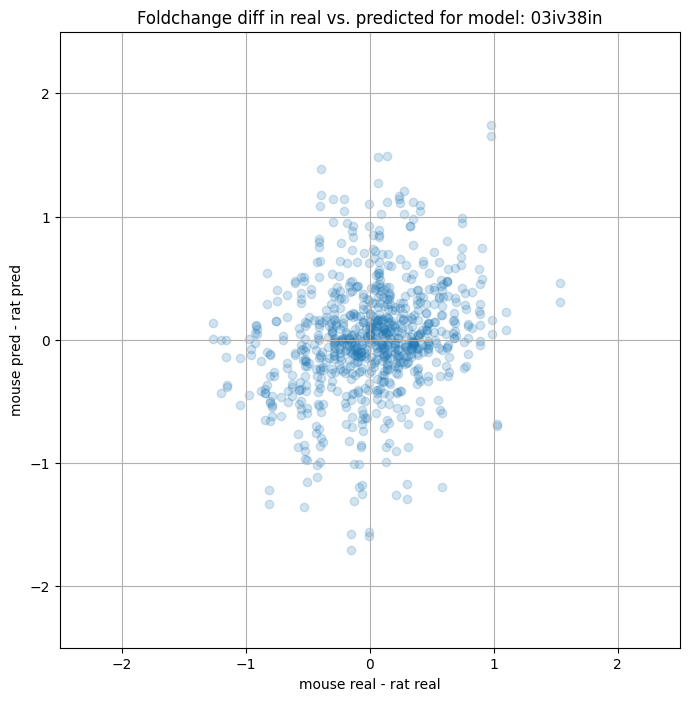

In [5]:
species = 'rat'
model = '03iv38in'

mac_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/{species}_liver_pos_ALL.bed', sep="\t", header=None)
mouse_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/mouse_liver_pos_ALL.bed', sep="\t", header=None)

one_to_one_peaks = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')
pred_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_{species}_VAL.csv', header=None)
val1_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val1/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
# val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val2/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val3/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val2/{species}_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

####################### make the ____ doubled predicted and true df
peaks = one_to_one_peaks[[4, 14]]

merged_df = peaks.merge(mac_qn, how='left', left_on=4, right_on=3, suffixes=('', '_mac'))

# Merge the result with df3 on col13 and df3['col3']
merged_df = merged_df.merge(mouse_qn, how='left', left_on=14, right_on=3, suffixes=('_MAC', '_mouse'))

# Subtract col4 values from df2 and df3
# merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
# res = merged_df[['4', 14, '4_mac', '4_mouse', 'result']]
# nan = res[res.isna().any(axis=1)]

# nan

####################### 

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)

mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_true', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=4, right_on=3).drop(14, axis=1)
# m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = merged_mac_real_pred.rename(columns={3:'mac_peak'}).drop(4, axis=1)

####################### make the mouse doubled predicted and true df

mouse_pred = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_mouse_VAL_TRAIN.csv', sep="\t", header=None)
mouse_real_neg=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', sep="\t", header=None)
mouse_real_pos=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/logPos/mouse_liver_VAL.narrowPeak', sep="\t", header=None)

real_neg_len = 2*len(mouse_real_neg)
real_pos_len = 2*len(mouse_real_pos)

mouse_pred_pos = mouse_pred[real_neg_len:real_neg_len+real_pos_len].reset_index(drop=True)

doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)


doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_true', 0:'mouse_pred'}).reset_index(drop=True)


merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=14, right_on=3)

m_mouse_pred = merged_mouse_pred.rename(columns={3:'mouse_peak'}).drop([14], axis=1)

####################### make bigboss mouse + query predicted and real info

bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)

bigboss['true'] = bigboss['mouse_true']-bigboss['mac_true']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']

mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']


same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
print(f'# of same sign for true difference and predicted difference: {same_sign.sum()} / {len(bigboss)} = {same_sign.sum() / len(bigboss)} %')

same_sign = np.sign(bigboss.loc[::2]['true']) == np.sign(bigboss.loc[::2]['avg_pred'])
print(f'# of same sign for true difference and averaged predicted difference: {same_sign.sum()} / {len(bigboss) / 2} = {same_sign.sum() / (len(bigboss) / 2)}%')

x = bigboss['true']
y = bigboss['pred']

print(pearson_spearman(x, y))

plt.figure(figsize=(8, 8))
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.xlabel(f'mouse real - {species} real')
plt.ylabel(f'mouse pred - {species} pred')
plt.title(f'Foldchange diff in real vs. predicted for model: {model}')
plt.grid(True)
plt.show()

# of same sign for true difference and predicted difference: 195 / 330 = 0.5909090909090909 %
# of same sign for true difference and averaged predicted difference: 98 / 165.0 = 0.593939393939394%
Pearson correlation coefficient: 0.2688, p-value: 7.168e-07
Spearman correlation coefficient: 0.2522, p-value: 3.501e-06
None


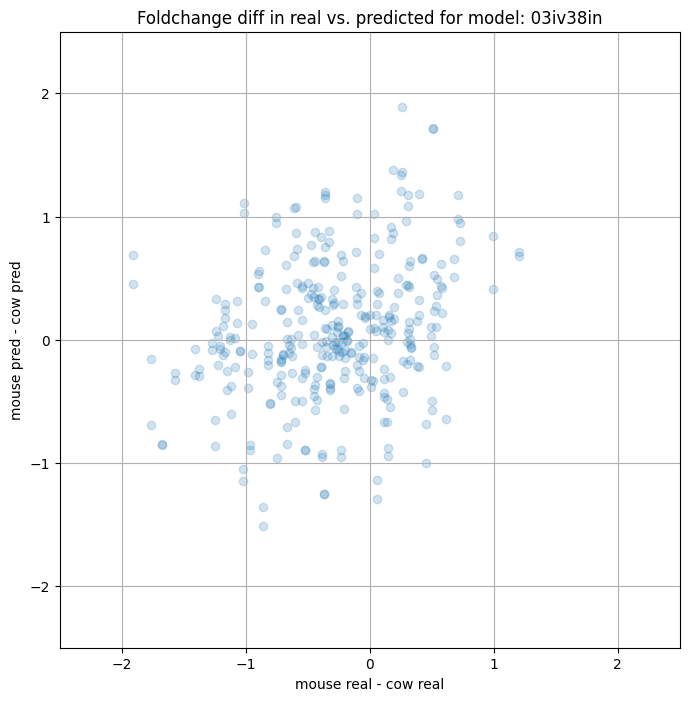

In [15]:
species = 'cow'
model = '03iv38in'

mac_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/{species}_liver_pos_ALL.bed', sep="\t", header=None)
mouse_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/mouse_liver_pos_ALL.bed', sep="\t", header=None)

one_to_one_peaks = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')
pred_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_{species}_VAL.csv', header=None)
val1_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val1/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
# val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val2/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val3/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val2/{species}_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

####################### make the ____ doubled predicted and true df
peaks = one_to_one_peaks[[4, 14]]

merged_df = peaks.merge(mac_qn, how='left', left_on=4, right_on=3, suffixes=('', '_mac'))

# Merge the result with df3 on col13 and df3['col3']
merged_df = merged_df.merge(mouse_qn, how='left', left_on=14, right_on=3, suffixes=('_MAC', '_mouse'))

# Subtract col4 values from df2 and df3
# merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
# res = merged_df[['4', 14, '4_mac', '4_mouse', 'result']]
# nan = res[res.isna().any(axis=1)]

# nan

####################### 

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)

mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_true', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=4, right_on=3).drop(14, axis=1)
# m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = merged_mac_real_pred.rename(columns={3:'mac_peak'}).drop(4, axis=1)

####################### make the mouse doubled predicted and true df

mouse_pred = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_mouse_VAL_TRAIN.csv', sep="\t", header=None)
mouse_real_neg=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', sep="\t", header=None)
mouse_real_pos=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/logPos/mouse_liver_VAL.narrowPeak', sep="\t", header=None)

real_neg_len = 2*len(mouse_real_neg)
real_pos_len = 2*len(mouse_real_pos)

mouse_pred_pos = mouse_pred[real_neg_len:real_neg_len+real_pos_len].reset_index(drop=True)

doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)


doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_true', 0:'mouse_pred'}).reset_index(drop=True)


merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=14, right_on=3)

m_mouse_pred = merged_mouse_pred.rename(columns={3:'mouse_peak'}).drop([14], axis=1)

####################### make bigboss mouse + query predicted and real info

bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)

bigboss['true'] = bigboss['mouse_true']-bigboss['mac_true']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']

mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']


same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
print(f'# of same sign for true difference and predicted difference: {same_sign.sum()} / {len(bigboss)} = {same_sign.sum() / len(bigboss)} %')

same_sign = np.sign(bigboss.loc[::2]['true']) == np.sign(bigboss.loc[::2]['avg_pred'])
print(f'# of same sign for true difference and averaged predicted difference: {same_sign.sum()} / {len(bigboss) / 2} = {same_sign.sum() / (len(bigboss) / 2)}%')

x = bigboss['true']
y = bigboss['pred']

print(pearson_spearman(x, y))

plt.figure(figsize=(8, 8))
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.xlabel(f'mouse real - {species} real')
plt.ylabel(f'mouse pred - {species} pred')
plt.title(f'Foldchange diff in real vs. predicted for model: {model}')
plt.grid(True)
plt.show()

# of same sign for true difference and predicted difference: 142 / 276 = 0.5144927536231884 %
# of same sign for true difference and averaged predicted difference: 72 / 138.0 = 0.5217391304347826%
Pearson correlation coefficient: 0.0788, p-value: 0.192
Spearman correlation coefficient: 0.0583, p-value: 0.3348
None


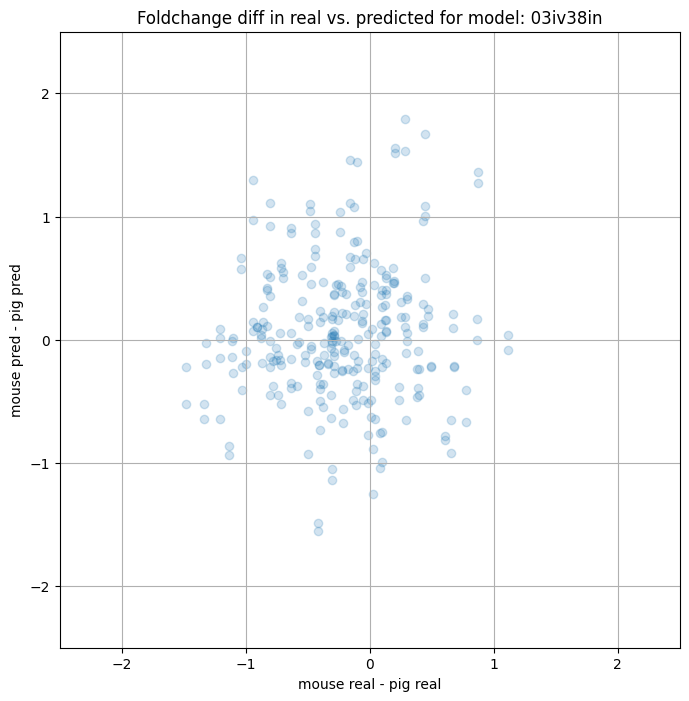

In [7]:
species = 'pig'
model = '03iv38in'

mac_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/{species}_liver_pos_ALL.bed', sep="\t", header=None)
mouse_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/mouse_liver_pos_ALL.bed', sep="\t", header=None)

one_to_one_peaks = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')
pred_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_{species}_VAL.csv', header=None)
val1_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val1/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
# val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val2/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val3/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val2/{species}_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

####################### make the ____ doubled predicted and true df
peaks = one_to_one_peaks[[4, 14]]

merged_df = peaks.merge(mac_qn, how='left', left_on=4, right_on=3, suffixes=('', '_mac'))

# Merge the result with df3 on col13 and df3['col3']
merged_df = merged_df.merge(mouse_qn, how='left', left_on=14, right_on=3, suffixes=('_MAC', '_mouse'))

# Subtract col4 values from df2 and df3
# merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
# res = merged_df[['4', 14, '4_mac', '4_mouse', 'result']]
# nan = res[res.isna().any(axis=1)]

# nan

####################### 

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)

mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_true', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=4, right_on=3).drop(14, axis=1)
# m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = merged_mac_real_pred.rename(columns={3:'mac_peak'}).drop(4, axis=1)

####################### make the mouse doubled predicted and true df

mouse_pred = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_mouse_VAL_TRAIN.csv', sep="\t", header=None)
mouse_real_neg=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', sep="\t", header=None)
mouse_real_pos=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/logPos/mouse_liver_VAL.narrowPeak', sep="\t", header=None)

real_neg_len = 2*len(mouse_real_neg)
real_pos_len = 2*len(mouse_real_pos)

mouse_pred_pos = mouse_pred[real_neg_len:real_neg_len+real_pos_len].reset_index(drop=True)

doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)


doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_true', 0:'mouse_pred'}).reset_index(drop=True)


merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=14, right_on=3)

m_mouse_pred = merged_mouse_pred.rename(columns={3:'mouse_peak'}).drop([14], axis=1)

####################### make bigboss mouse + query predicted and real info

bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)

bigboss['true'] = bigboss['mouse_true']-bigboss['mac_true']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']

mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']


same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
print(f'# of same sign for true difference and predicted difference: {same_sign.sum()} / {len(bigboss)} = {same_sign.sum() / len(bigboss)} %')

same_sign = np.sign(bigboss.loc[::2]['true']) == np.sign(bigboss.loc[::2]['avg_pred'])
print(f'# of same sign for true difference and averaged predicted difference: {same_sign.sum()} / {len(bigboss) / 2} = {same_sign.sum() / (len(bigboss) / 2)}%')

x = bigboss['true']
y = bigboss['pred']

print(pearson_spearman(x, y))

plt.figure(figsize=(8, 8))
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.xlabel(f'mouse real - {species} real')
plt.ylabel(f'mouse pred - {species} pred')
plt.title(f'Foldchange diff in real vs. predicted for model: {model}')
plt.grid(True)
plt.show()

In [3]:
bigboss

,4,mouse_chr,1,2,mouse_peak,mouse_true,mouse_pred,mac_chr,1,2,mac_peak,mac_true,mac_pred,true,pred,mouse_pred_avg,mac_pred_avg,avg_pred
0,peak3999,chr8,6572228,6572728,peak19410,2.641920,1.645476,chr11,79915168,79915668,peak3999,1.767188,0.863699,0.874732,0.781777,1.611510,0.679292,0.932218
1,peak3999,chr8,6572228,6572728,peak19410,2.641920,1.577545,chr11,79915168,79915668,peak3999,1.767188,0.494885,0.874732,1.082660,NaN,NaN,NaN
2,peak19034,chr9,6668368,6668868,peak20464,2.435192,1.359379,chr9,38188680,38189180,peak19034,3.148468,1.211549,-0.713276,0.147831,1.392123,1.150621,0.241502
3,peak19034,chr9,6668368,6668868,peak20464,2.435192,1.424866,chr9,38188680,38189180,peak19034,3.148468,1.089693,-0.713276,0.335173,NaN,NaN,NaN
4,peak19028,chr9,7603249,7603749,peak20478,2.949985,1.317796,chr9,37297025,37297525,peak19028,2.553404,1.554308,0.396581,-0.236513,1.355928,1.552033,-0.196105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,peak6596,chr8,126920787,126921287,peak20441,2.004851,1.067432,chr14,60258998,60259498,peak6596,2.314623,1.839792,-0.309772,-0.772360,NaN,NaN,NaN
272,peak3138,chr8,128025157,128025657,peak20446,1.777192,0.425384,chr10,62116080,62116580,peak3138,2.085514,0.689626,-0.308322,-0.264242,0.425293,0.633096,-0.207802
273,peak3138,chr8,128025157,128025657,peak20446,1.777192,0.425202,chr10,62116080,62116580,peak3138,2.085514,0.576565,-0.308322,-0.151363,NaN,NaN,NaN
274,peak3134,chr8,128551345,128551845,peak20452,1.744713,1.487037,chr10,61616739,61617239,peak3134,3.084151,1.608124,-1.339437,-0.121087,1.487086,1.621835,-0.134749


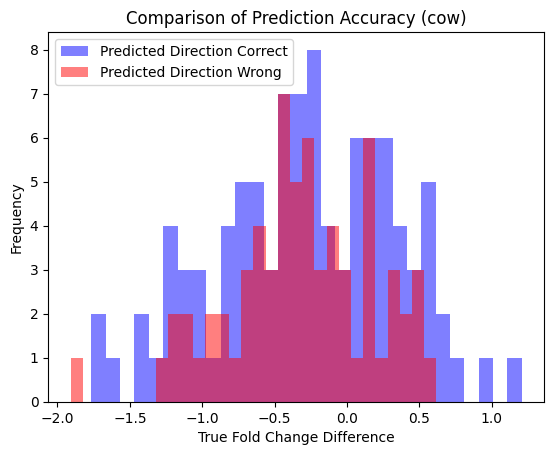

In [16]:
correct_mask = (bigboss['true'] * bigboss['avg_pred']) > 0
incorrect_mask = (bigboss['true'] * bigboss['avg_pred']) < 0

# Extract values for histogram plotting
correct_values = bigboss.loc[correct_mask, 'true']
incorrect_values = bigboss.loc[incorrect_mask, 'true']

# Plot both histograms in one figure
plt.hist(correct_values, bins=30, alpha=0.5, color='blue', label='Predicted Direction Correct')
plt.hist(incorrect_values, bins=30, alpha=0.5, color='red', label='Predicted Direction Wrong')

# Labels and title
plt.xlabel('True Fold Change Difference')
plt.ylabel('Frequency')
plt.title(f'Comparison of Prediction Accuracy ({species})')
plt.legend()  # Show legend to distinguish colors

# Show the plot
plt.show()

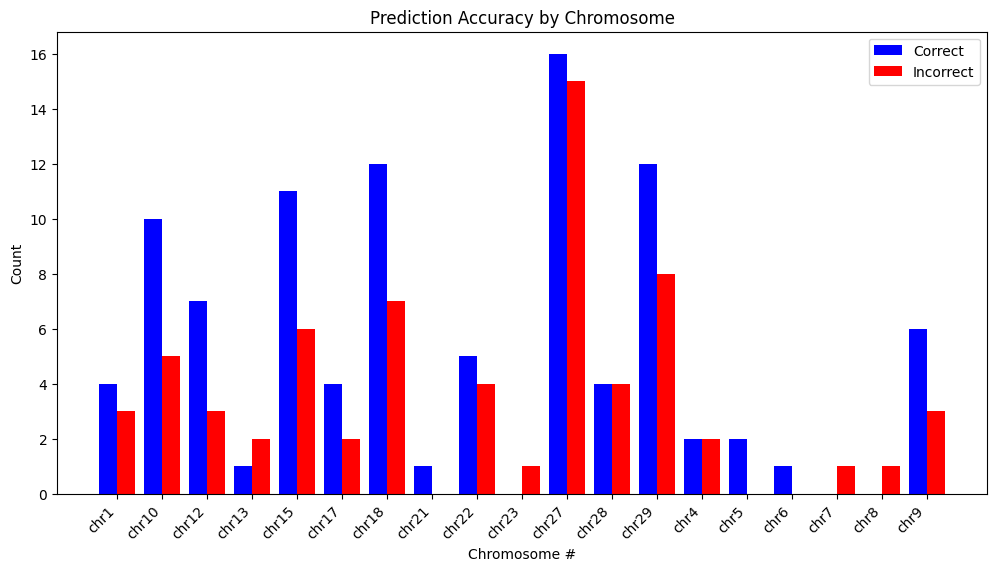

In [17]:
chr_counts = bigboss.groupby('mac_chr').agg(
    correct=('true', lambda x: (x[correct_mask]).count()),
    incorrect=('true', lambda x: (x[incorrect_mask]).count())
).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4  # Adjust width of bars
x_indexes = np.arange(len(chr_counts['mac_chr']))

# Plot bars for correct and incorrect predictions
ax.bar(x_indexes - bar_width/2, chr_counts['correct'], width=bar_width, color='blue', label='Correct')
ax.bar(x_indexes + bar_width/2, chr_counts['incorrect'], width=bar_width, color='red', label='Incorrect')

# X-axis labels and formatting
ax.set_xticks(x_indexes)
ax.set_xticklabels(chr_counts['mac_chr'], rotation=45, ha='right')

# Labels and title
plt.xlabel('Chromosome #')
plt.ylabel('Count')
plt.title('Prediction Accuracy by Chromosome')
plt.legend()

# Show plot
plt.show()

In [14]:
bigboss

,4,mouse_chr,1,2,mouse_peak,mouse_true,mouse_pred,mac_chr,1,2,mac_peak,mac_true,mac_pred,true,pred,mouse_pred_avg,mac_pred_avg,avg_pred,correct_mask,incorrect_mask
0,peak3999,chr8,6572228,6572728,peak19410,2.641920,1.645476,chr11,79915168,79915668,peak3999,1.767188,0.863699,0.874732,0.781777,1.611510,0.679292,0.932218,True,False
1,peak3999,chr8,6572228,6572728,peak19410,2.641920,1.577545,chr11,79915168,79915668,peak3999,1.767188,0.494885,0.874732,1.082660,NaN,NaN,NaN,False,False
2,peak19034,chr9,6668368,6668868,peak20464,2.435192,1.359379,chr9,38188680,38189180,peak19034,3.148468,1.211549,-0.713276,0.147831,1.392123,1.150621,0.241502,False,True
3,peak19034,chr9,6668368,6668868,peak20464,2.435192,1.424866,chr9,38188680,38189180,peak19034,3.148468,1.089693,-0.713276,0.335173,NaN,NaN,NaN,False,False
4,peak19028,chr9,7603249,7603749,peak20478,2.949985,1.317796,chr9,37297025,37297525,peak19028,2.553404,1.554308,0.396581,-0.236513,1.355928,1.552033,-0.196105,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,peak6596,chr8,126920787,126921287,peak20441,2.004851,1.067432,chr14,60258998,60259498,peak6596,2.314623,1.839792,-0.309772,-0.772360,NaN,NaN,NaN,False,False
272,peak3138,chr8,128025157,128025657,peak20446,1.777192,0.425384,chr10,62116080,62116580,peak3138,2.085514,0.689626,-0.308322,-0.264242,0.425293,0.633096,-0.207802,True,False
273,peak3138,chr8,128025157,128025657,peak20446,1.777192,0.425202,chr10,62116080,62116580,peak3138,2.085514,0.576565,-0.308322,-0.151363,NaN,NaN,NaN,False,False
274,peak3134,chr8,128551345,128551845,peak20452,1.744713,1.487037,chr10,61616739,61617239,peak3134,3.084151,1.608124,-1.339437,-0.121087,1.487086,1.621835,-0.134749,True,False
